In [53]:
import cudaq
from typing import List
import numpy as np 
from cudaq import spin
from scipy.optimize import minimize
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

cudaq.set_target("nvidia")

df_input = np.loadtxt("qc_pca_train_input_bace_12q2")
df_classes = np.loadtxt("qc_pca_train_classes_bace_12q2") - 1

df_test_input = np.loadtxt("qc_pca_test_input_bace_12q2")
df_test_classes = np.loadtxt("qc_pca_test_classes_bace_12q2") - 1

m = df_classes.size  #Number of data samples 
num_classes = int(max(df_classes)) + 1 #Number of classes
num_qubits = df_input.shape[1]
ansatz_layers = 1
maxiter = 50
num_theta = num_qubits * ansatz_layers
theta_values = np.zeros(num_theta)
data_values  = df_input
class_values = df_classes

def gen_default_prob_class(num_qubits, num_classes):
    prob_class = np.zeros(2**num_qubits)
    for i in range(2**num_qubits):
        prob_class[i] = i % num_classes
    return prob_class

prob_class = gen_default_prob_class(num_qubits, num_classes)

In [54]:
@cudaq.kernel
def kernel(data: np.ndarray, theta: np.ndarray):
    
    q = cudaq.qvector(num_qubits)
    
    #Data encoding
    for i in range(num_qubits):
        ry(data[i], q[i])
    for i in range(num_qubits - 1):
        x.ctrl(q[i], q[i + 1])

    #Parameterised ansatz
    for i in range(ansatz_layers):
        for j in range(num_qubits):
            ry(theta[i * num_qubits + j], q[j])
        for j in range(num_qubits - 1):
            x.ctrl(q[j], q[j + 1])

def cost_function(theta_values):
    cost = 0
    for i in range(m):
        c = 0
        sv = np.array(cudaq.get_state(kernel, data_values[i], theta_values))
        prob = softmax(np.real(np.abs(sv) ** 2))
        for j in range(2**num_qubits):
            if prob_class[j] == class_values[i]:
                c += prob[j]
        cost += -np.log(c)
    cost = cost / m
    return cost

def find_prob(data_values, theta_values):
    p = np.zeros(len(data_values))
    for i in range(len(data_values)):
        c = 0
        sv = np.array(cudaq.get_state(kernel, data_values[i], theta_values))
        prob = np.real(np.abs(sv) ** 2)
        for j in range(2**num_qubits):
            if prob_class[j] == class_values[i]:
                c += prob[j]
        p[i] = c
    return p

In [55]:
loss = []
t = []
def callback(xk):
    loss.append(cost_function(xk))
    t.append(xk)

result = minimize(cost_function, theta_values, method='COBYLA', callback=callback, options={'maxiter': maxiter})

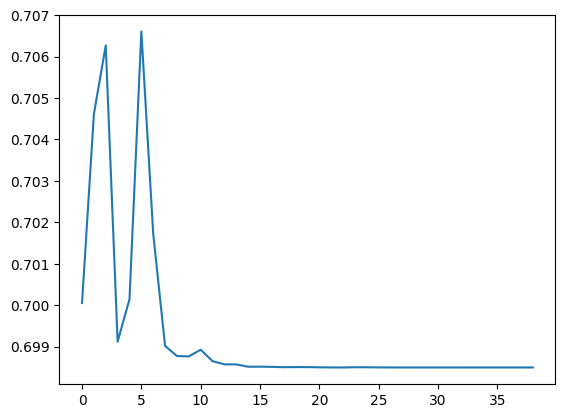

In [56]:
plt.plot(loss)

In [57]:
t_final = t[-1]
p_final = find_prob(data_values,t_final)
print(p_final)

[0.65946863 0.64888927 0.64893817 ... 0.1178961  0.63603087 0.49686592]


In [58]:
print(t)
#Why is the first set of angles [1,0] instead of [0,0]?

[array([1., 0.]), array([1., 1.]), array([ 1.87623816, -0.48187828]), array([ 1.43811908, -0.24093914]), array([ 1.39655203, -0.73920833]), array([1.87138919, 0.00861449]), array([ 1.65475413, -0.11616232]), array([ 1.39364599, -0.35776013]), array([ 1.3352355 , -0.33552359]), array([ 1.21182042, -0.31568126]), array([ 1.20047722, -0.3771433 ]), array([ 1.22002296, -0.25372185]), array([ 1.2275372 , -0.19167521]), array([ 1.21791161, -0.12992087]), array([ 1.24915706, -0.129388  ]), array([ 1.3078223 , -0.10783248]), array([ 1.25979244, -0.15877254]), array([ 1.27473895, -0.15421814]), array([ 1.29017217, -0.15177759]), array([ 1.27701615, -0.1616914 ]), array([ 1.2845535 , -0.14206022]), array([ 1.27867605, -0.12758278]), array([ 1.27723032, -0.11202481]), array([ 1.2616175, -0.1126417]), array([ 1.29257141, -0.10905977]), array([ 1.28490086, -0.11054229]), array([ 1.27336522, -0.11145927]), array([ 1.2772489 , -0.11593101]), array([ 1.27917635, -0.11624666]), array([ 1.27579122, -0.1

In [43]:
#Use only for binary classification
p_refined = np.zeros(m)
for i in range(m):
    if class_values[i] == 1:
        p_refined[i] = p_final[i]
    else:
        p_refined[i] = 1 - p_final[i]
roc_auc_score(class_values, p_refined)

0.5227938813997346

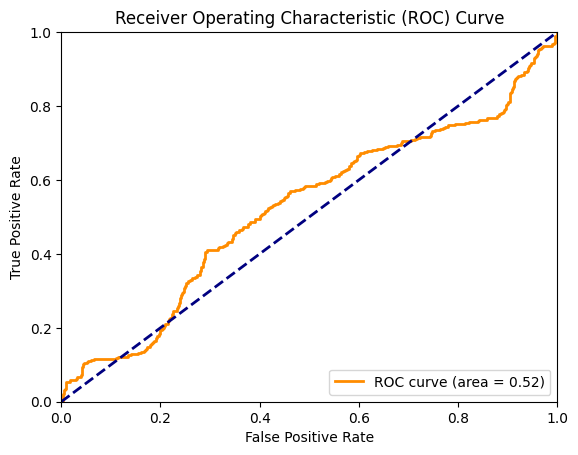

In [44]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(class_values, p_refined)

# Compute ROC AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [45]:
p_test_final = find_prob(df_test_input,t_final)
#Use only for binary classification
p_test_refined = np.zeros(len(df_test_classes))
for i in range(len(df_test_classes)):
    if df_test_classes[i] == 1:
        p_test_refined[i] = p_final[i]
    else:
        p_test_refined[i] = 1 - p_test_final[i]
roc_auc_score(df_test_classes, p_test_refined)

0.5590579710144927